In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai import PowerSpectrum
from censai import PhysicalModelv2
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import h5py
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter
from astropy.visualization import ImageNormalize, LogStretch
from tqdm import tqdm
from glob import glob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")
plt.style.use("science")
params = {'legend.fontsize': 27,
          'figure.figsize': (10, 10),
         'axes.labelsize': 27,
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'figure.titlesize': 40
         }
pylab.rcParams.update(params)
phys = PhysicalModelv2(pixels=128, image_fov=7.68, kappa_fov=7.68, method="fft")

In [4]:
# hf = h5py.File(os.getenv('CENSAI_PATH') + "results/testset_501_pred_reoptimized.h5")

In [23]:
# plt.plot(hf['chi_squared'])

In [24]:
# plt.imshow(hf['lens_reoptimized'], cmap="bone", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3, vmax=1), origin="lower")

# Posterior optimization

In [41]:
path = os.getenv('CENSAI_PATH') + "results/"
pattern = "optim_posterior_highSNR_*.h5"
pattern2 = "optim_posterior_medSNR*h5"
hf = []
for file in glob(path + pattern):
    hf.append(h5py.File(file, "r"))
for file in glob(path + pattern2):
    hf.append(h5py.File(file, "r"))
B = 10
dataset = lambda b: "lenses128hst_TNG_rau_200k_control_denoised_testset_validated" if b < 10 else "lenses128hst_TNG_rau_200k_control_denoised_testset2_validated"

In [42]:
hf[0][dataset(0)].keys()

<KeysViewHDF5 ['chi_squared', 'chi_squared_reoptimized', 'chi_squared_reoptimized_series', 'kappa', 'kappa_coherence_spectrum', 'kappa_coherence_spectrum_reoptimized', 'kappa_fov', 'kappa_frequencies', 'kappa_optim_mse', 'kappa_optim_mse_series', 'kappa_pred', 'kappa_pred_reoptimized', 'kappa_prior', 'latent_kappa_gt_distance_end', 'latent_kappa_gt_distance_init', 'latent_source_gt_distance_end', 'latent_source_gt_distance_init', 'lens', 'lens_coherence_spectrum', 'lens_coherence_spectrum2', 'lens_coherence_spectrum_reoptimized', 'lens_fov', 'lens_frequencies', 'lens_pred', 'lens_pred_reoptimized', 'lens_prior', 'noise_rms', 'psf', 'psf_fwhm', 'sampled_kappa_optim_mse_series', 'sampled_source_optim_mse_series', 'source', 'source_coherence_spectrum', 'source_coherence_spectrum2', 'source_coherence_spectrum_reoptimized', 'source_fov', 'source_frequencies', 'source_optim_mse', 'source_optim_mse_series', 'source_pred', 'source_pred_reoptimized', 'source_prior']>

Text(0.5, 0, 'Reoptimisation step')

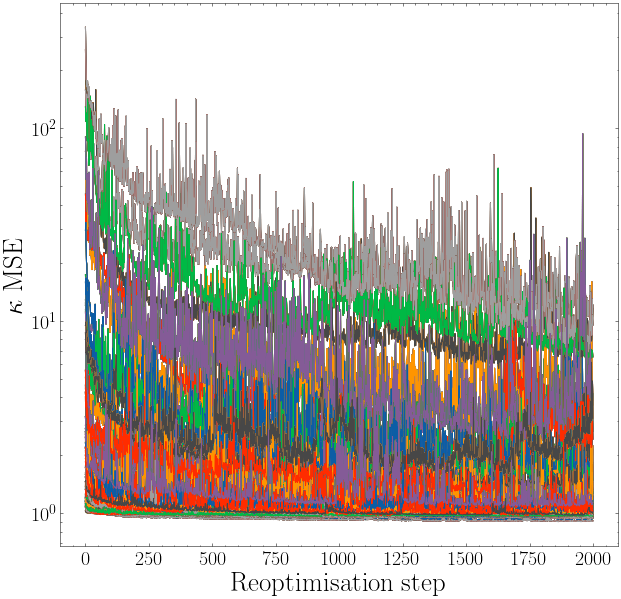

In [46]:
# for b in range(len(hf)):
for j in range(0, 100):
    b = j // B
    for i in range(B):
#         plt.plot(hf[b][dataset(b)]["chi_squared_reoptimized_series"][i, -1])
        plt.plot(hf[b][dataset(b)]["chi_squared_reoptimized_series"][i, -1])
#         plt.plot(hf[b][dataset(b)]["latent_source_gt_distance_init"][i])
# plt.ylim(0.8)
# plt.axhline(1, color="k", lw=3)
plt.yscale("log")
# plt.ylabel(r"$\chi^2_\nu$")
# plt.ylabel(r"source MSE")
plt.ylabel(r"$\kappa$ MSE")
plt.xlabel("Reoptimisation step")
# plt.savefig("reopt_kappa_mse_first100.png", facecolor="white")

In [47]:
source_mse_prior = []
kappa_mse_prior = []
source_mse_reopt = []
kappa_mse_reopt = []
for i in range(len(hf)):
    for j in range(B):
        source_pred = hf[i][dataset(i)]["source_pred"][j][-1]
        source = hf[i][dataset(i)]["source"][j]
        source_mse_prior.append(((source_pred - source)**2).mean())
        kappa_pred = hf[i][dataset(i)]["kappa_pred"][j][-1]
        kappa = hf[i][dataset(i)]["kappa"][j]
        kappa_mse_prior.append(((kappa - kappa_pred)**2).mean())
        source_reopt = hf[i][dataset(i)]["source_pred_reoptimized"][j]
        source_mse_reopt.append(((source_reopt - source)**2).mean())
        kappa_reopt = hf[i][dataset(i)]["kappa_pred_reoptimized"][j]
        kappa_mse_reopt.append(((kappa - kappa_pred)**2).mean())


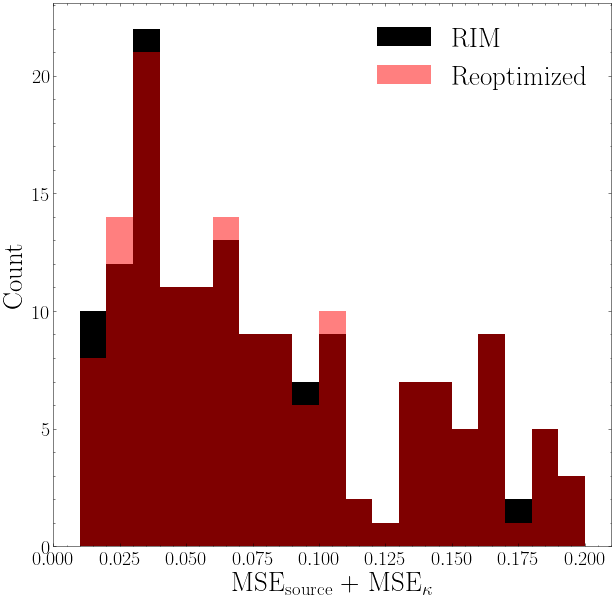

In [55]:
plt.hist([s + k for s, k in zip(source_mse_prior, kappa_mse_prior)], bins=20, color="k", label="RIM", range=(0, 0.2))
plt.hist([s + k for s, k in zip(source_mse_reopt, kappa_mse_reopt)], bins=20, color="r", label="Reoptimized", alpha=0.5, range=(0, 0.2))
plt.legend()
plt.xlim(0)
plt.ylabel("Count")
plt.xlabel("MSE$_{\mathrm{source}}$ + MSE$_{\kappa}$");
plt.savefig("prior_reopt.png")

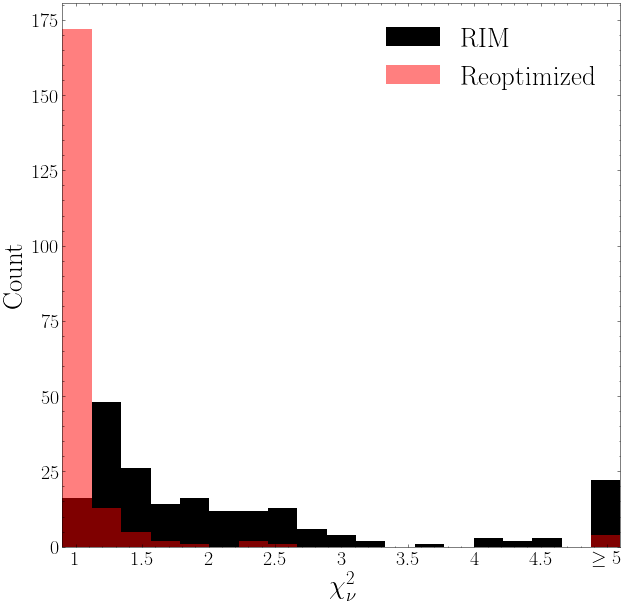

In [49]:
chisq = []
chisq_ro = []
noise_rms_list = []
for i in range(len(hf)):
    chisq.append(hf[i][dataset(i)]["chi_squared"][:, -1])
    noise_rms_list.append(hf[i][dataset(i)]["noise_rms"])
    chisq_ro.append(hf[i][dataset(i)]["chi_squared_reoptimized"][:, -1])
#     _chisq_ro = hf[i][dataset]["chi_squared_reoptimized"]
#     for j in range(B):
#         __chisq_ro = _chisq_ro[j] # this is the actual value of the reoptimized chi squared. We should make an entry for it because this is confusing
#         __chisq_ro = __chisq_ro[__chisq_ro > 0].min()
#         chisq_ro.append(__chisq_ro)
chisq = np.concatenate(chisq)
noise_rms_list = np.concatenate(noise_rms_list)
# chisq_ro = np.array(chisq_ro)
chisq_ro = np.concatenate(chisq_ro)
    
# noise_rms = np.array(hf[dataset]["noise_rms"])
bins = np.linspace(0.9, 5.1, 20)
# bins = np.concatenate([bins, [1000]])
plt.hist(np.minimum(chisq, 5.1), bins=bins, histtype="stepfilled", color="k", label="RIM");
plt.hist(np.minimum(chisq_ro, 5.1), bins=bins, histtype="stepfilled", color="r", alpha=0.5, label="Reoptimized");

# plt.hist(chi_squared[:, -1], bins=bins, histtype="step", color="k");
x = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ["1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", r"$\geq 5$"]
plt.xticks(x, labels)
# plt.title("Quality of Fit Distribution")
plt.xlim(0.9, 5.1)
plt.ylabel("Count")
plt.xlabel(r"$\chi^2_\nu$")
plt.legend()
plt.savefig("chi_squared_distribution")


# SLGD sampling (unadjusted)

In [68]:
# path = os.getenv('CENSAI_PATH') + "results/"
# pattern = "slgd_sample*"
# hf = []
# for file in glob(path + pattern):
#     hf.append(h5py.File(file, "r"))
# B = 2

In [69]:
# dataset = lambda b: "lenses128hst_TNG_rau_200k_control_denoised_testset_validated"
# hf[0][dataset(0)].keys()

In [70]:
# # for b in range(len(hf)):
# for j in range(10):
#     b = j // B
#     for i in range(B):
#         plt.plot(hf[b][dataset(b)]["chi_squared_reoptimized_series"][i])
# #         plt.plot(hf[b][dataset(b)]["source_optim_mse_series"][i])
# # plt.ylim(0.8)
# # plt.axhline(1, color="k", lw=3)
# plt.yscale("log")
# # plt.ylabel(r"$\chi^2_\nu$")
# # plt.ylabel(r"source MSE")
# plt.ylabel(r"$\kappa$ MSE")
# plt.xlabel("Reoptimisation step")
# # plt.savefig("reopt_kappa_mse_first100.png", facecolor="white")

In [71]:
# plt.hist(source_pred.ravel())
# plt.yscale("log")

In [72]:
# N = 8 # 13 = Full page + description
# # For RIMSource A0 set
# # start = 0 # representative sample 3
# # start = 80 # represnetative sample 1
# # start = 190  # representative sample 2
# # start = 100 # 80 is good, 100 is insane, 800 show case a very interesting key shaped lens, 1920 is also insane -> 5 blobs
# start = 0


# fig, axs = plt.subplots(N, 10, figsize=(40, 4 * N))

# for i in range(N):
#     j = i + start
#     b = j // B
#     k = j % B
#     lens = hf[b][dataset(b)][f"lens"][k].squeeze()
#     source = hf[b][dataset(b)][f"source"][k].squeeze()
#     kappa = hf[b][dataset(b)][f"kappa"][k].squeeze()
# #     lens_pred = hf[b][dataset(b)][f"lens_pred"][k].squeeze()
#     lens_pred = hf[b][dataset(b)][f"lens_pred_reoptimized_var"][k].squeeze()
# #     source_pred = hf[b][dataset(b)][f"source_pred"][k][-1].squeeze()
#     source_pred = hf[b][dataset(b)][f"source_pred_reoptimized_var"][k].squeeze()
# #     kappa_pred = hf[b][dataset(b)][f"kappa_pred"][k][-1].squeeze()
#     kappa_pred = hf[b][dataset(b)][f"kappa_pred_reoptimized_var"][k].squeeze()
# #     chi_squared = chisq[j]
# #     chi_squared = chisq_ro[j]
#     noise_rms = hf[b][dataset(b)]["noise_rms"][k]
#     intensity_cmap = "twilight" # "twilight"
#     a = 1000
#     i_min = 1e-3

# #     axs[i, 1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
#     axs[i, 1].imshow(source, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
# #     axs[i, 2].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
#     axs[i, 2].imshow(source_pred, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
#     axs[i, 3].imshow(source - source_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
#     axs[i, 4].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
#     axs[i, 5].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
#     axs[i, 6].imshow(np.log10(kappa) - np.log10(kappa_pred), cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
# #     axs[i, 7].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
#     axs[i, 7].imshow(lens, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
# #     axs[i, 8].imshow(lens_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
#     axs[i, 8].imshow(lens_pred, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
#     axs[i, 9].imshow((lens - lens_pred)/noise_rms/5, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
# #     axs[i, 0].annotate(f"{chi_squared:.2f}", xy=(0.4, 0.4), xycoords="axes fraction", size=35)

    
# for i in range(N):            
#     for j in range(10):
#         axs[i, j].axis("off")

# fig.subplots_adjust(right=0.95)
# cbar_ax = fig.add_axes([0.96, 0.67, 0.01, 0.2])
# fig.colorbar(ScalarMappable(cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
# cbar_ax.set_yticklabels(["$\leq 0.1$", "1", "10", "$\geq 100$"], fontsize=30) 
# cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=50, fontsize=40)
# cbar_ax.yaxis.set_label_position("right")


# fig.subplots_adjust(right=0.95)
# cbar_ax = fig.add_axes([0.96, 0.33 + .07, 0.01, 0.2])
# fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
# cbar_ax.set_yticklabels(["$\leq 0.001$", "0.01", "0.1", "1"], fontsize=30) 
# cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=40)
# cbar_ax.yaxis.set_label_position("right")

# fig.subplots_adjust(right=0.95)
# cbar_ax = fig.add_axes([0.96, 0.13, 0.01, 0.2])
# fig.colorbar(ScalarMappable(cmap="seismic", norm=Normalize(vmin=-1, vmax=1)), cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1])
# cbar_ax.set_yticklabels(["$\leq -1$", "0.5", "0", "0.5", "$\geq 1$"], fontsize=30) 
# cbar_ax.set_ylabel(r"Residuals", rotation=270, labelpad=60, fontsize=40)
# cbar_ax.yaxis.set_label_position("right")

# # axs[0, 0].set_title("Source")
# # axs[0, 1].set_title("Source prédite")
# # axs[0, 2].set_title("Différence")
# # axs[0, 3].set_title("$\kappa$")
# # axs[0, 4].set_title("$\hat{\kappa}_T$")
# # axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
# # axs[0, 6].set_title("Observation ($\mathbf{y}$)")
# # axs[0, 7].set_title("Prédiction ($\mathbf{\hat{y}}_T$)")
# # axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
# # plt.subplots_adjust(wspace=0, hspace=0)
# # plt.savefig(f"../results/rim_pred{start:d}.png")

# # fig.suptitle("Validation set")
# axs[0, 0].set_title(r"$\chi^2_\nu$", pad=20, fontsize=40)
# axs[0, 1].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
# axs[0, 2].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
# axs[0, 3].set_title(r"$\mathbf{s} - \mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
# axs[0, 4].set_title("$\kappa$", pad=20, fontsize=40)
# axs[0, 5].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
# axs[0, 6].set_title("$\log\kappa - \log\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
# axs[0, 7].set_title("$\mathbf{y}$", pad=20, fontsize=40)
# axs[0, 8].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
# axs[0, 9].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/5\sigma_{\mathrm{noise}}$", pad=20, fontsize=40)
# plt.subplots_adjust(wspace=0, hspace=-0.1)
# # plt.savefig("tests_rimsu128hstv4_representative_sample_reoptim2.png")
# # plt.savefig("rim_sample_first100_fulldr.png", facecolor="white")

# # plt.savefig("tests_rimsu128hstv4_representative_sample2.png")
# # plt.savefig("tests_rimsu128hstv4_representative_sample3.png")

In [54]:
path = os.getenv('CENSAI_PATH') + "results/"
# path = "/media/alexandre/Seagate/Ecole/Automne2021/Censai/results/"
# pattern = "RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839_RIMSource128hstv3_control_009_A1_L3_FLM0.0_211108220845_*.h5"
pattern = "highSNR_*h5"
pattern2 = "medSNR*h5"
# pattern = "reoptim2*.h5"
hf = []
for file in glob(path + pattern):
    hf.append(h5py.File(file, "r"))
for file in glob(path + pattern2):
    hf.append(h5py.File(file, "r"))
# hf = h5py.File(path + "RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839_RIMSource128hstv3_control_009_A1_L3_FLM0.0_211108220845_01.h5", 'r')
# B = 50 # example per files
# B = 25
B = 10

In [55]:
dataset = lambda b: "lenses128hst_TNG_rau_200k_control_denoised_testset_validated" if b < 300 else "lenses128hst_TNG_rau_200k_control_denoised_testset2_validated"
# dataset = "lenses128hst_TNG_rau_200k_control_denoised_testset2_validated"\
B = hf[0][dataset(0)]["source"].shape[0]
hf[0][dataset(0)].keys()

<KeysViewHDF5 ['chi_squared', 'chi_squared2', 'chi_squared_reoptimized', 'chi_squared_reoptimized_series', 'kappa', 'kappa_coherence_spectrum', 'kappa_coherence_spectrum_reoptimized', 'kappa_fov', 'kappa_frequencies', 'kappa_optim_mse', 'kappa_optim_mse_series', 'kappa_pred', 'kappa_pred_reoptimized', 'lens', 'lens_coherence_spectrum', 'lens_coherence_spectrum2', 'lens_coherence_spectrum_reoptimized', 'lens_fov', 'lens_frequencies', 'lens_pred', 'lens_pred2', 'lens_pred_reoptimized', 'noise_rms', 'psf', 'psf_fwhm', 'source', 'source_coherence_spectrum', 'source_coherence_spectrum2', 'source_coherence_spectrum_reoptimized', 'source_fov', 'source_frequencies', 'source_optim_mse', 'source_optim_mse_series', 'source_pred', 'source_pred2', 'source_pred_reoptimized']>

In [31]:
# for b in range(len(hf)):
for j in range(3560, 3660):
    b = j // B
    for i in range(B):
#         plt.plot(hf[b][dataset(b)]["chi_squared_reoptimized_series"][i])
        plt.plot(hf[b][dataset(b)]["kappa_optim_mse_series"][i])
# plt.ylim(0.8)
# plt.axhline(1, color="k", lw=3)
# plt.yscale("log")
# plt.ylabel(r"$\chi^2_\nu$")
# plt.ylabel(r"source MSE")
plt.ylabel(r"$\kappa$ MSE")
plt.xlabel("Reoptimisation step")
# plt.savefig("reopt_kappa_mse_first100.png", facecolor="white")

IndexError: list index out of range

In [57]:
source_mse_prior = []
kappa_mse_prior = []
source_mse_reopt = []
kappa_mse_reopt = []
for i in range(len(hf)):
    for j in range(B):
        source_pred = hf[i][dataset(i)]["source_pred"][j][-1]
        source = hf[i][dataset(i)]["source"][j]
        source_mse_prior.append(((source_pred - source)**2).mean())
        kappa_pred = hf[i][dataset(i)]["kappa_pred"][j][-1]
        kappa = hf[i][dataset(i)]["kappa"][j]
        kappa_mse_prior.append(((kappa - kappa_pred)**2).mean())
        source_reopt = hf[i][dataset(i)]["source_pred_reoptimized"][j]
        source_mse_reopt.append(((source_reopt - source)**2).mean())
        kappa_reopt = hf[i][dataset(i)]["kappa_pred_reoptimized"][j]
        kappa_mse_reopt.append(((kappa - kappa_pred)**2).mean())


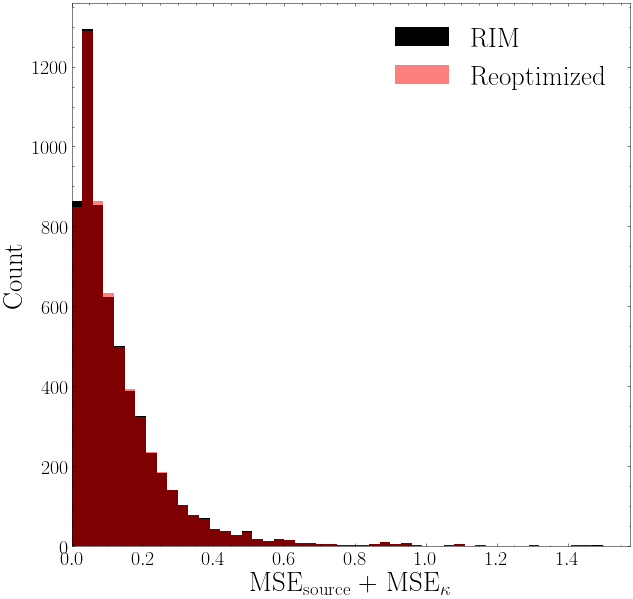

In [58]:
plt.hist([s + k for s, k in zip(source_mse_prior, kappa_mse_prior)], bins=50, color="k", label="RIM", range=(0, 1.5))
plt.hist([s + k for s, k in zip(source_mse_reopt, kappa_mse_reopt)], bins=50, color="r", label="Reoptimized", alpha=0.5, range=(0, 1.5))
plt.legend()
plt.xlim(0)
plt.ylabel("Count")
plt.xlabel("MSE$_{\mathrm{source}}$ + MSE$_{\kappa}$");
plt.savefig("prior_reopt.png")

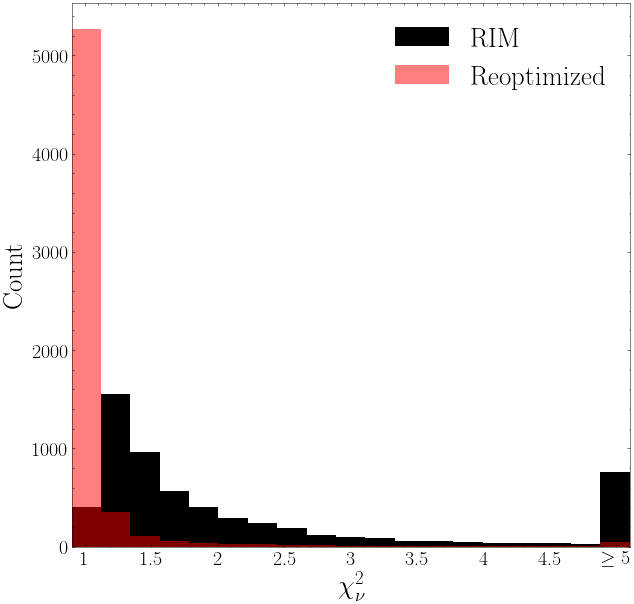

In [59]:
chisq = []
chisq_ro = []
noise_rms_list = []
for i in range(len(hf)):
    chisq.append(hf[i][dataset(i)]["chi_squared"][:, -1])
    noise_rms_list.append(hf[i][dataset(i)]["noise_rms"])
    chisq_ro.append(hf[i][dataset(i)]["chi_squared_reoptimized"])
#     _chisq_ro = hf[i][dataset]["chi_squared_reoptimized"]
#     for j in range(B):
#         __chisq_ro = _chisq_ro[j] # this is the actual value of the reoptimized chi squared. We should make an entry for it because this is confusing
#         __chisq_ro = __chisq_ro[__chisq_ro > 0].min()
#         chisq_ro.append(__chisq_ro)
chisq = np.concatenate(chisq)
noise_rms_list = np.concatenate(noise_rms_list)
# chisq_ro = np.array(chisq_ro)
chisq_ro = np.concatenate(chisq_ro)
    
# noise_rms = np.array(hf[dataset]["noise_rms"])
bins = np.linspace(0.9, 5.1, 20)
# bins = np.concatenate([bins, [1000]])
plt.hist(np.minimum(chisq, 5.1), bins=bins, histtype="stepfilled", color="k", label="RIM");
plt.hist(np.minimum(chisq_ro, 5.1), bins=bins, histtype="stepfilled", color="r", alpha=0.5, label="Reoptimized");

# plt.hist(chi_squared[:, -1], bins=bins, histtype="step", color="k");
x = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ["1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", r"$\geq 5$"]
plt.xticks(x, labels)
# plt.title("Quality of Fit Distribution")
plt.xlim(0.9, 5.1)
plt.ylabel("Count")
plt.xlabel(r"$\chi^2_\nu$")
plt.legend()
plt.savefig("chi_squared_distribution")


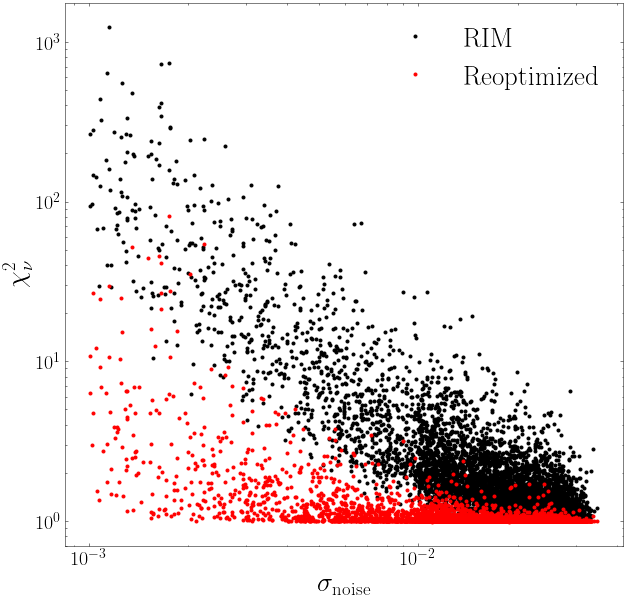

In [60]:
plt.plot(noise_rms_list, chisq, "k.", label="RIM")
plt.plot(noise_rms_list, chisq_ro, "r.", label="Reoptimized")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$\chi^2_\nu$")
plt.xlabel(r"$\sigma_{\mathrm{noise}}$")
plt.legend()
plt.savefig("chisq_vs_noise.png")

In [ ]:
N = 100 # 13 = Full page + description
# For RIMSource A0 set
# start = 0 # representative sample 3
# start = 80 # represnetative sample 1
# start = 190  # representative sample 2
# start = 100 # 80 is good, 100 is insane, 800 show case a very interesting key shaped lens, 1920 is also insane -> 5 blobs
# start = 3560
start = 0


fig, axs = plt.subplots(N, 10, figsize=(40, 4 * N))

for i in range(N):
    j = i + start
    b = j // B
    k = j % B
    lens = hf[b][dataset(b)][f"lens"][k].squeeze()
    source = hf[b][dataset(b)][f"source"][k].squeeze()
    kappa = hf[b][dataset(b)][f"kappa"][k].squeeze()
#     lens_pred = hf[b][dataset(b)][f"lens_pred"][k].squeeze()
#     lens_pred = hf[b][dataset(b)][f"lens_pred_reoptimized"][k].squeeze()
    lens_pred = hf[b][dataset(b)][f"lens_prior"][k].squeeze()
#     source_pred = hf[b][dataset(b)][f"source_pred"][k][-1].squeeze()
#     source_pred = hf[b][dataset(b)][f"source_pred_reoptimized"][k].squeeze()
    source_pred = hf[b][dataset(b)][f"source_prior"][k].squeeze()
#     kappa_pred = hf[b][dataset(b)][f"kappa_pred"][k][-1].squeeze()
#     kappa_pred = hf[b][dataset(b)][f"kappa_pred_reoptimized"][k].squeeze()
    kappa_pred = 10**hf[b][dataset(b)][f"kappa_prior"][k].squeeze()
#     chi_squared = chisq[j]
    chi_squared = chisq_ro[j]
    noise_rms = hf[b][dataset(b)]["noise_rms"][k]
    intensity_cmap = "twilight" # "twilight"
    a = 1000
    i_min = 1e-3

#     axs[i, 1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 1].imshow(source, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
#     axs[i, 2].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(source_pred, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
    axs[i, 3].imshow(source - source_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 4].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 6].imshow(np.log10(kappa) - np.log10(kappa_pred), cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
#     axs[i, 7].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 7].imshow(lens, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
#     axs[i, 8].imshow(lens_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 8].imshow(lens_pred, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
    axs[i, 9].imshow((lens - np.maximum(lens_pred, 0))/noise_rms/5, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 0].annotate(f"{chi_squared:.2f}", xy=(0.4, 0.4), xycoords="axes fraction", size=35)

    
for i in range(N):            
    for j in range(10):
        axs[i, j].axis("off")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.67, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$\leq 0.1$", "1", "10", "$\geq 100$"], fontsize=30) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=50, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.33 + .07, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)), cax=cbar_ax, ticks=[0.001, 0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$\leq 0.001$", "0.01", "0.1", "1"], fontsize=30) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=40)
cbar_ax.yaxis.set_label_position("right")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.13, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="seismic", norm=Normalize(vmin=-1, vmax=1)), cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1])
cbar_ax.set_yticklabels(["$\leq -1$", "0.5", "0", "0.5", "$\geq 1$"], fontsize=30) 
cbar_ax.set_ylabel(r"Residuals", rotation=270, labelpad=60, fontsize=40)
cbar_ax.yaxis.set_label_position("right")

# axs[0, 0].set_title("Source")
# axs[0, 1].set_title("Source prédite")
# axs[0, 2].set_title("Différence")
# axs[0, 3].set_title("$\kappa$")
# axs[0, 4].set_title("$\hat{\kappa}_T$")
# axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
# axs[0, 6].set_title("Observation ($\mathbf{y}$)")
# axs[0, 7].set_title("Prédiction ($\mathbf{\hat{y}}_T$)")
# axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"../results/rim_pred{start:d}.png")

# fig.suptitle("Validation set")
axs[0, 0].set_title(r"$\chi^2_\nu$", pad=20, fontsize=40)
axs[0, 1].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
axs[0, 2].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[0, 3].set_title(r"$\mathbf{s} - \mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[0, 4].set_title("$\kappa$", pad=20, fontsize=40)
axs[0, 5].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[0, 6].set_title("$\log\kappa - \log\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[0, 7].set_title("$\mathbf{y}$", pad=20, fontsize=40)
axs[0, 8].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
axs[0, 9].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/5\sigma_{\mathrm{noise}}$", pad=20, fontsize=40)
plt.subplots_adjust(wspace=0, hspace=-0.1)
# plt.savefig("tests_rimsu128hstv4_representative_sample_reoptim2.png")
# plt.savefig("rim_sample_first100_fulldr.png", facecolor="white")

# plt.savefig("tests_rimsu128hstv4_representative_sample2.png")
# plt.savefig("tests_rimsu128hstv4_representative_sample3.png")

In [10]:
chisq
# indices = np.where(noise_rms > 0.03)[0]
# indices = np.where((chisq_ro > 3) & (noise_rms_list > 0.01))[0]
# indices = np.where((chisq_ro < 1.005))[0]
indices = np.argsort(np.abs(chisq_ro - 1))

indices

array([ 425, 3588, 3325, ...,  336, 1717, 2504])

In [11]:
len(indices)

6000

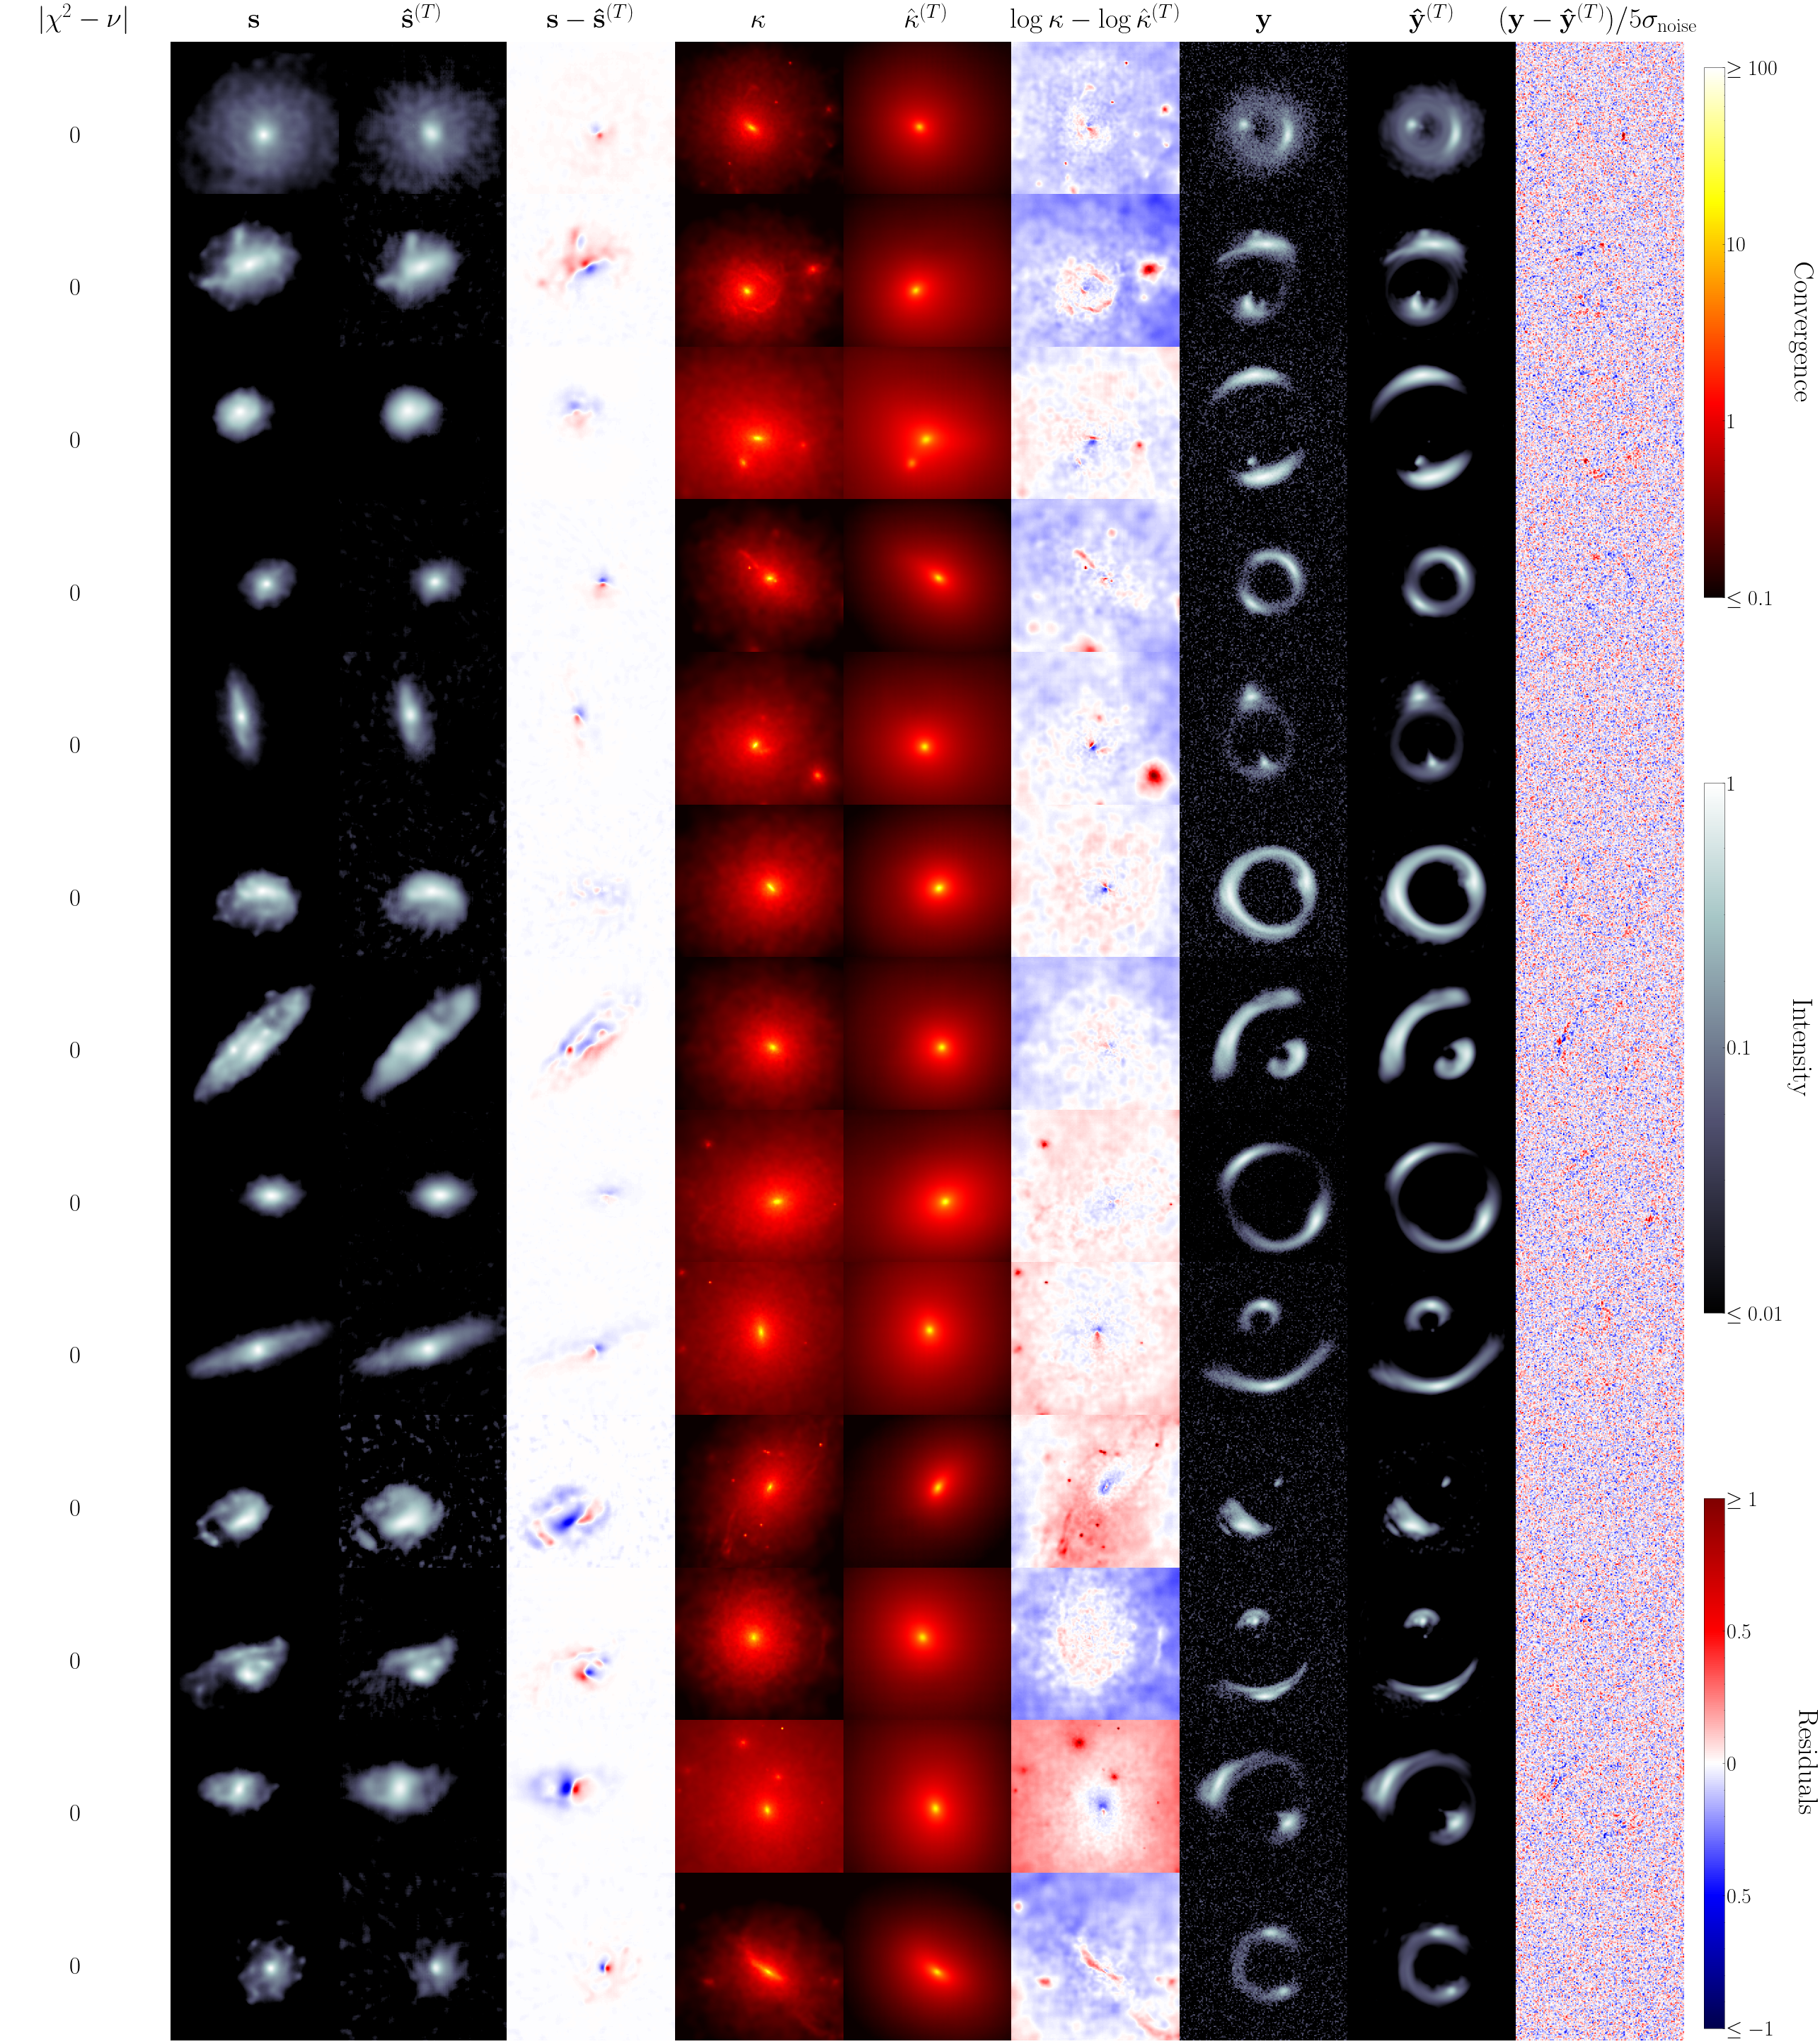

In [12]:
N = 13
fig, axs = plt.subplots(N, 10, figsize=(40, 4 * N))
# For paper
# 187 202 205 235 244 265 273 302 310 330 345 402 2131 2203 2260 2275 2414 2471 2498 2505 2014 2055 3131 3161 3164 3167 3249 3296 3321 3332 3329 3361 3373 3404 3443
# Multiple blob kappa
# 0 42 46 49 58 69 164 187 202 205 235 273 302 310 2131 2260 2414 2498 2055 3131 3164 3167 3321 3361 3373
# Special kappa like edge on disc
# 7 12 118 241 2060 2275 3259
# Nice source
# 10 50 65 227 258 265 272 348 2203 2471 2014 3161 3329 3363 3404
# Interesting ring
# 25 2505 3296
# Would be interesting to have uncertainties on those
# 26 80 110 3175
# Perfect residuals
# 40 83 97 187 402 2471
# Very high SNR
# 56 320
# Default back to SIE + perfect residuals
# 140 145 219
# Horseshoe like
# 244 345 3332
# This one is so precise thatresidual tell the story of a third kappa blob
# 306
# 3 image system
# 330
# THis image show very well the degenracy btw kapp aand source
# 3175
# This shows how lensing is not in fact sensitive to the distribution of matter in the center
# 3280
# This is pure chaos
# 3296
# Interestingly, kappa has wrong orientatioN!
# 3363
# 5 image system
# 3368
# Wrong source size
# 3371
# Literraly perfect
# 3443

start = 13
# _indices = [3443, 3363, 3280, 330, 306, 3296, 3404, 241, 2414, 2014, 3404, 2471, 3161] # bestcase1
# _indices = [302, 3368, 330, 3443, 402, 140, 244, 10, 0, 2498, 3164, 3371, 2505] # bestcase2

# for i, ell in enumerate(_indices):
for i in range(N):
    j = indices[i + start]
#     j = indices[ell]
    b = j // B
    k = j % B
    lens = hf[b][dataset(b)][f"lens"][k].squeeze()
    source = hf[b][dataset(b)][f"source"][k].squeeze()
    kappa = hf[b][dataset(b)][f"kappa"][k].squeeze()
#     lens_pred = hf[b][dataset][f"lens_pred"][k].squeeze()
    lens_pred = hf[b][dataset(b)][f"lens_pred_reoptimized"][k].squeeze()
    source_pred = hf[b][dataset(b)][f"source_pred_reoptimized"][k].squeeze()
#     kappa_pred = hf[b][dataset][f"kappa_pred"][k][-1].squeeze()
    kappa_pred = hf[b][dataset(b)][f"kappa_pred_reoptimized"][k].squeeze()
    chi_squared = chisq_ro[j]
    noise_rms = hf[b][dataset(b)]["noise_rms"][k]
    intensity_cmap = "bone" # "twilight"
    a = 100
    i_min = 1e-2

#     axs[i, 1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 1].imshow(source, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
#     axs[i, 2].imshow(source_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(source_pred, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
    axs[i, 3].imshow(source - source_pred, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 4].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 6].imshow(np.log10(kappa) - np.log10(kappa_pred), cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
#     axs[i, 7].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 7].imshow(lens, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
#     axs[i, 8].imshow(lens_pred, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 8].imshow(lens_pred, cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1), origin="lower")
    axs[i, 9].imshow((lens - lens_pred)/noise_rms/5, cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    
    axs[i, 0].annotate(fr"{abs(chi_squared*128**2 - 128**2):.0f}", xy=(0.4, 0.4), xycoords="axes fraction", size=35)
#     axs[i, 0].annotate(fr"$\chi^2_\nu = ${chi_squared:.1f}", xy=(0.2, 0.4), xycoords="axes fraction", size=35)


    
for i in range(N):            
    for j in range(10):
        axs[i, j].axis("off")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.67, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$\leq 0.1$", "1", "10", "$\geq 100$"], fontsize=30) 
cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=50, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.33 + .07, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)), cax=cbar_ax, ticks=[0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["$\leq 0.01$", "0.1", "1"], fontsize=30) 
cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=40, fontsize=40)
cbar_ax.yaxis.set_label_position("right")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.13, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="seismic", norm=Normalize(vmin=-2, vmax=2)), cax=cbar_ax, ticks=[-2, -1, 0, 1, 2])
cbar_ax.set_yticklabels(["$\leq -1$", "0.5", "0", "0.5", "$\geq 1$"], fontsize=30) 
cbar_ax.set_ylabel(r"Residuals", rotation=270, labelpad=60, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


axs[0, 0].set_title(r"$|\chi^2-\nu|$", pad=20, fontsize=40)
axs[0, 1].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
axs[0, 2].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[0, 3].set_title(r"$\mathbf{s} - \mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[0, 4].set_title("$\kappa$", pad=20, fontsize=40)
axs[0, 5].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[0, 6].set_title("$\log\kappa - \log\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[0, 7].set_title("$\mathbf{y}$", pad=20, fontsize=40)
axs[0, 8].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
axs[0, 9].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/5\sigma_{\mathrm{noise}}$", pad=20, fontsize=40)
plt.subplots_adjust(wspace=0, hspace=-0.1)
plt.savefig("perfectcases.png", facecolor="white")

100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


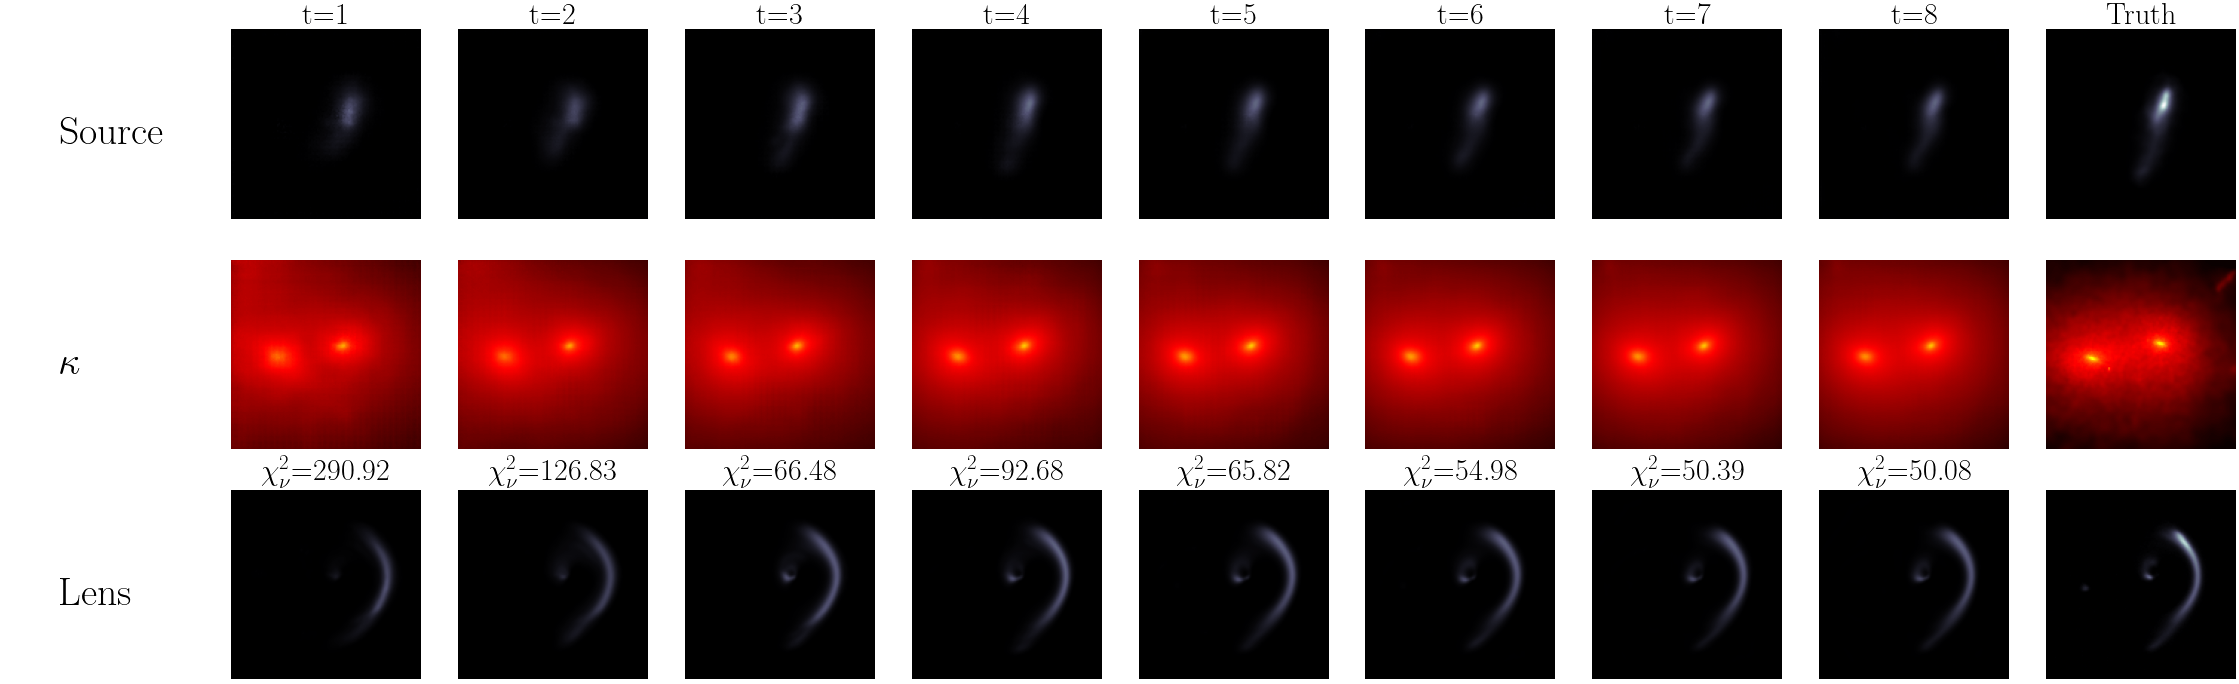

In [18]:
# k = 120 # interesting, but only a single kappa blob
# k = 125 # bad fit, might be interesting
k = 501 # two kappa blob, very interesting

fig, axs = plt.subplots(3, 10, figsize=(40, 12))
lens = hf[dataset(b)][f"lens"][k].squeeze()
source = hf[dataset(b)][f"source"][k].squeeze()
kappa = hf[dataset(b)][f"kappa"][k].squeeze()
lens_pred = hf[dataset(b)][f"lens_pred"][k].squeeze()
source_pred = hf[dataset][f"source_pred"][k][-1].squeeze()
kappa_pred = hf[dataset][f"kappa_pred"][k][-1].squeeze()
chi_squared = hf[dataset]["chi_squared"][k][-1] * 2
psf = hf["dataset"]["k"].squeeze()
noise_rms = hf[dataset]["noise_rms"][k]

axs[0, 0].annotate("Source", xy=(0.3, 0.4), xycoords="axes fraction", fontsize=40)
axs[0, 0].axis("off")
axs[1, 0].annotate(r"$\kappa$", xy=(0.3, 0.4), xycoords="axes fraction", fontsize=40)
axs[1, 0].axis("off")
axs[2, 0].annotate("Lens", xy=(0.3, 0.4), xycoords="axes fraction", fontsize=40)
axs[2, 0].axis("off")
for i in tqdm(range(1, 9)):
    lens = phys.forward(source_pred[i-1][None, ..., None], kappa_pred[i-1][None, ..., None], psf[None, ..., None])[0, ..., 0]
    axs[0, i].imshow(source_pred[i-1], cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"t={i}")
    axs[1, i].imshow(kappa_pred[i-1], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[1, i].axis("off")
    axs[2, i].set_title(fr"$\chi^2_\nu$={chi_squared[i-1]:.2f}", pad=10)
    axs[2, i].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[2, i].axis("off")
    
# fig.suptitle("Validation set")
axs[0, -1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
axs[0, -1].axis("off")
axs[0, -1].set_title(f"Truth")
axs[1, -1].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[1, -1].axis("off")
axs[2, -1].imshow(true_lens, cmap="bone", vmin=0, vmax=1, origin="lower")
axs[2, -1].axis("off")
# plt.savefig(f"RIMSU128hstv4_optim_example_{k}.png")

In [85]:
((source_pred - source)**2).mean(axis=(1, 2))

array([0.00070318, 0.00065931, 0.00073074, 0.00081619, 0.00088637,
       0.00094533, 0.00098925, 0.00102202], dtype=float32)

In [86]:
((kappa_pred - kappa)**2).mean(axis=(1, 2))

array([0.12869336, 0.12094872, 0.12233438, 0.12467327, 0.12583284,
       0.1268778 , 0.12755385, 0.12803097], dtype=float32)

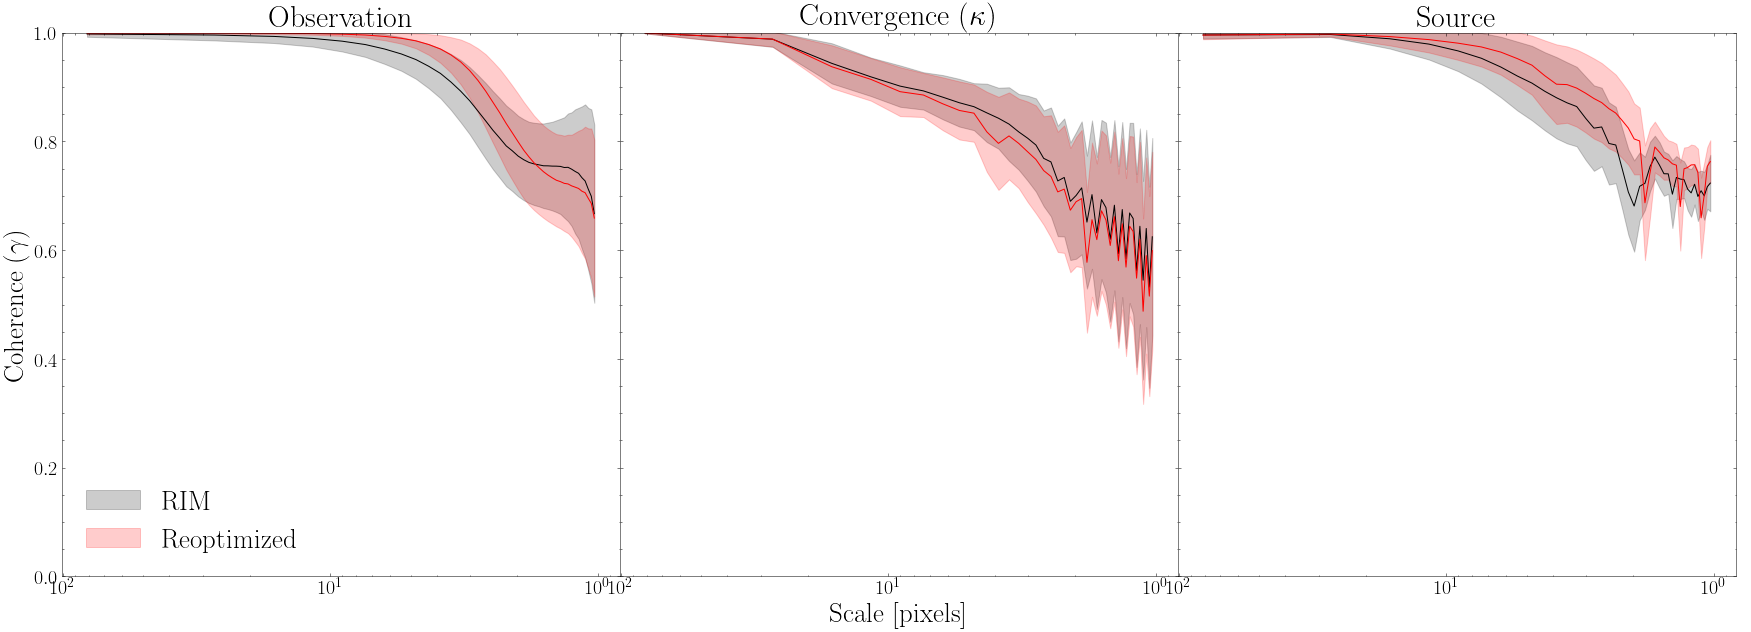

In [22]:
# Need to recompute the power spectrum, since it wasn't saved in h5 before 2021-12-20

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
color = "k"
color2 = "r"

# lens
r_re = []
r = []
for i in range(len(hf)):
    r_re.append(hf[i][dataset(i)]["lens_coherence_spectrum_reoptimized"])
    r.append(hf[i][dataset(i)]["lens_coherence_spectrum"])
r_re = np.concatenate(r_re, axis=0)
r = np.concatenate(r, axis=0)
f = np.array(hf[0][dataset(0)]["lens_frequencies"])
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
rr_mean = r_re.mean(axis=0)
rr_std = r_re.std(axis=0)
lam = 1/f/2


ax1.plot(lam, r_mean, "-", color=color)
ax1.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"RIM")
# ax1.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax1.plot(lam, rr_mean, "-", color=color2)
ax1.fill_between(lam, rr_mean - rr_std, rr_mean + rr_std, color=color2, alpha=0.2, label=r"Reoptimized")
# ax1.fill_between(lam, rr_mean - 2 * rr_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_{\gamma_r}$")

ax1.invert_xaxis()
ax1.set_xscale("log")
ax1.set_ylim(0, 1)
# ax1.set_ylabel(r"$\gamma = \dfrac{P_{\mathbf{y}\mathbf{\hat{y}}}}{\sqrt{P_{\mathbf{y}\mathbf{y}} P_{\mathbf{\hat{y}}\mathbf{\hat{y}}}}}$")
ax1.set_ylabel(r"Coherence ($\gamma$)")
ax1.set_title(r"Observation")
ax1.legend(loc="lower left")

# kappa
r_re = []
r = []
for i in range(len(hf)):
    r_re.append(hf[i][dataset(i)]["kappa_coherence_spectrum_reoptimized"])
    r.append(hf[i][dataset(i)]["kappa_coherence_spectrum"])
r_re = np.concatenate(r_re, axis=0)
r = np.concatenate(r, axis=0)
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
rr_mean = r_re.mean(axis=0)
rr_std = r_re.std(axis=0)
lam = 1/f/2



ax2.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax2.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
# ax2.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax2.plot(lam, rr_mean, "-", color=color2, label=r"$\bar{\gamma}_{r}$")
ax2.fill_between(lam, rr_mean - rr_std, rr_mean + rr_std, color=color2, alpha=0.2, label=r"$\bar{\gamma}_r \pm \sigma_{\gamma_r}$")
# ax2.fill_between(lam, rr_mean - 2 * rr_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_{\gamma_r}$")
ax2.invert_xaxis()
ax2.set_xscale("log")
ax2.set_ylim(0, 1)
ax2.set_title("Convergence ($\kappa$)")
# plt.xlim(128, 3)
# ax2.legend(loc="lower left")


# source
r_re = []
r = []
for i in range(len(hf)):
    r_re.append(hf[i][dataset(i)]["source_coherence_spectrum_reoptimized"])
    r.append(hf[i][dataset(i)]["source_coherence_spectrum"])
r_re = np.concatenate(r_re, axis=0)
r = np.concatenate(r, axis=0)
bins=r.shape[1]

r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
rr_mean = r_re.mean(axis=0)
rr_std = r_re.std(axis=0)
lam = 1/f/2

ax3.plot(lam, r_mean, "-", color=color, label=r"$\bar{\gamma}$")
ax3.fill_between(lam, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2, label=r"$\bar{\gamma} \pm \sigma_\gamma$")
# ax3.fill_between(lam, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_\gamma$")
ax3.plot(lam, rr_mean, "-", color=color2, label=r"$\bar{\gamma}_{r}$")
ax3.fill_between(lam, rr_mean - rr_std, rr_mean + rr_std, color=color2, alpha=0.2, label=r"$\bar{\gamma}_r \pm \sigma_{\gamma_r}$")
# ax3.fill_between(lam, rr_mean - 2 * rr_std, r_mean + 2 * r_std, color=color2, alpha=0.1, label=r"$\bar{\gamma} \pm 2\sigma_{\gamma_r}$")
ax3.invert_xaxis()
ax3.set_xscale("log")
ax3.set_title("Source")
# plt.xlim(128, 3)
# ax3.legend(loc="lower left")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Scale [pixels]")

plt.subplots_adjust(wspace=0, hspace=0);
# fig.suptitle("Reconstruction coherence spectrum", y=0.99);
plt.savefig("coherence_spectrum.png", facecolor="white")

In [55]:

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
# gridsize=20

# # lens
# r = np.array(hf[dataset]["lens_coherence_spectrum"])
# f = np.array(hf[dataset]["lens_frequencies"])
# point_cloud = np.stack([np.tile(f, r.shape[0]), r.ravel()], axis=1)
# ax1.hexbin(point_cloud[:, 0], point_cloud[:, 1], gridsize=gridsize, cmap='Reds', norm=LogNorm(vmin=1, vmax=2000), mincnt=1)
# ax1.set_ylim(0, 1)
# # ax1.set_xlim(0, 0.5)
# ax1.set_ylabel(r"$\gamma = \dfrac{P_{\mathbf{y}\mathbf{\hat{y}}}}{\sqrt{P_{\mathbf{y}\mathbf{y}} P_{\mathbf{\hat{y}}\mathbf{\hat{y}}}}}$")
# ax1.set_title("Lens")


# # # kappa
# r = np.array(hf[dataset]["kappa_coherence_spectrum"])
# f = np.array(hf[dataset]["kappa_frequencies"])
# point_cloud = np.stack([np.tile(f, r.shape[0]), r.ravel()], axis=1)
# ax2.hexbin(point_cloud[:, 0], point_cloud[:, 1], gridsize=gridsize, cmap='Reds', norm=LogNorm(vmin=1, vmax=2000), mincnt=1)
# ax2.set_ylim(0, 1)
# # ax2.set_xlim(0, 0.5)
# ax2.set_title("Deflector")


# # source
# r = np.array(hf[dataset]["source_coherence_spectrum"])
# f = np.array(hf[dataset]["source_frequencies"])
# point_cloud = np.stack([np.tile(f, r.shape[0]), r.ravel()], axis=1)
# ax3.hexbin(point_cloud[:, 0], point_cloud[:, 1], gridsize=gridsize, cmap='Reds', norm=LogNorm(vmin=1, vmax=2000), mincnt=1)
# ax3.set_ylim(0, 1)
# # ax3.set_xlim(0, 0.5)
# ax3.set_title("Source")

# divider = make_axes_locatable(ax3)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(ScalarMappable(cmap="Reds", norm=LogNorm(vmin=1, vmax=2000)), cax=cax)
# cax.set_ylabel("Count in cell", rotation=270, labelpad=30)


# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel(r"Frequency [pixels$^{-1}$]")

# plt.subplots_adjust(wspace=0, hspace=0);
# fig.suptitle("Reconstruction coherence spectrum", y=0.99);
# plt.savefig("RIMSU128hstv4_coherence_spectrum.png")

In [32]:
noise_rms = []
psf_fwhm = []
chisq = []
for b in range(len(hf)):
#     chisq.append(hf[b][dataset]["chi_squared_reoptimized"])
#     chisq.append(hf[b][dataset]["chi_squared"][:, -1])
    _chisq_ro = hf[i][dataset]["chi_squared_reoptimized"]
    for j in range(50):
        __chisq_ro = _chisq_ro[j] # this is the actual value of the reoptimized chi squared. We should make an entry for it because this is confusing
        __chisq_ro = __chisq_ro[__chisq_ro > 0].min()
        chisq.append(__chisq_ro)
    noise_rms.append(hf[b][dataset]["noise_rms"])
    psf_fwhm.append(hf[b][dataset]["psf_fwhm"])
# chisq = np.concatenate(chisq)
chisq = np.array(chisq)
noise_rms = np.concatenate(noise_rms)
psf_fwhm = np.concatenate(psf_fwhm)

In [35]:
x = np.linspace(noise_rms.min(), noise_rms.max(), 50)
y = np.linspace(psf_fwhm.min(), psf_fwhm.max(), 50)
z = griddata((noise_rms, psf_fwhm), chisq, (x[None, :], y[:, None]), method='linear')

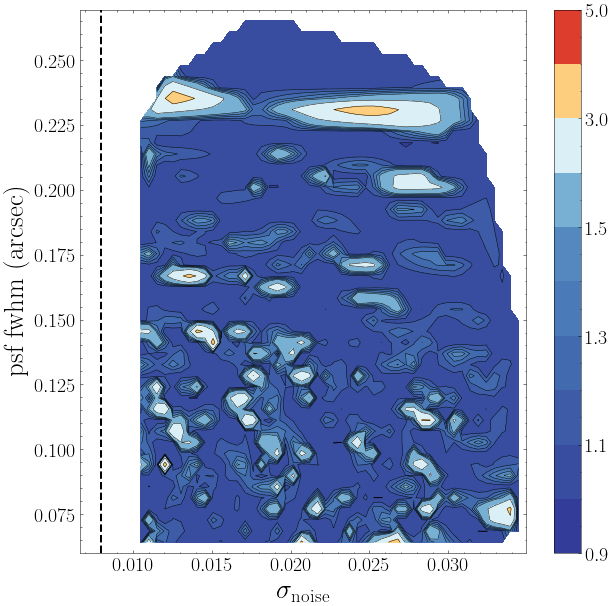

In [38]:
levels = [0.9, 1, 2, 3, 4, 5, 10, 100, 500]
levels = [0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5]

plt.contour(x, y, z, levels=levels, linewidths=0.5, colors='k')
plt.contourf(x, y, z, levels=levels, cmap="RdYlBu_r", norm=Normalize(vmin=0.9, vmax=5))
plt.colorbar()
plt.ylabel("psf fwhm (arcsec)")
plt.xlabel("$\sigma_{\mathrm{noise}}$")
plt.axvline(0.008, color="k", lw=2, ls="--")
# plt.plot(noise_rms, psf_fwhm, 'ko', ms=3)

In [139]:
# path = os.getenv('CENSAI_PATH') + "results/"
# pattern = "RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839_RIMSource128hstv3_control_009_A1_L3_FLM0.0_211108220845_*.h5"
# # pattern = "highSNR_*h5"
# hf = []
# for file in glob(path + pattern):
#     try:
#         hf.append(h5py.File(file, "r+"))
#     except:
#         continue

In [145]:
# hf[b][dataset].keys()

<KeysViewHDF5 ['chi_squared', 'chi_squared2', 'chi_squared_reoptimized', 'kappa', 'kappa_coherence_spectrum', 'kappa_coherence_spectrum_reoptimized', 'kappa_fov', 'kappa_frequencies', 'kappa_optim_mse', 'kappa_pred', 'kappa_pred_reoptimized', 'lens', 'lens_coherence_spectrum', 'lens_coherence_spectrum2', 'lens_coherence_spectrum_reoptimized', 'lens_fov', 'lens_frequencies', 'lens_pred', 'lens_pred2', 'lens_pred_reoptimized', 'noise_rms', 'psf', 'psf_fwhm', 'source', 'source_coherence_spectrum', 'source_coherence_spectrum2', 'source_coherence_spectrum_reoptimized', 'source_fov', 'source_frequencies', 'source_optim_mse', 'source_pred', 'source_pred2', 'source_pred_reoptimized']>

In [147]:
# ps = PowerSpectrum(bins=40, pixels=128)
# ps_lens = []
# for b in tqdm(range(len(hf))):
#     for i in range(B):
#         lens = hf[b][dataset]["lens"][i].squeeze()
#         lens_p = hf[b][dataset]["lens_pred_reoptimized"][i].squeeze()
#         hf[b][dataset]["lens_coherence_spectrum_reoptimized"][i] = ps.cross_correlation_coefficient(lens[None, ...], lens_p[None, ...])
#         source = hf[b][dataset]["source"][i].squeeze()
#         source_p = hf[b][dataset]["source_pred_reoptimized"][i].squeeze()
#         hf[b][dataset]["source_coherence_spectrum_reoptimized"][i] = ps.cross_correlation_coefficient(source[None, ...], source_p[None, ...])
#         kappa = hf[b][dataset]["kappa"][i].squeeze()
#         kappa_p = hf[b][dataset]["kappa_pred_reoptimized"][i].squeeze()
#         hf[b][dataset]["kappa_coherence_spectrum_reoptimized"][i] = ps.cross_correlation_coefficient(np.log10(kappa[None, ...]), np.log10(kappa_p[None, ...]))

100%|██████████| 93/93 [19:48<00:00, 12.78s/it]
